In [ ]:
!pip un
\

install gym

Found existing installation: gym 0.17.3
Uninstalling gym-0.17.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gym-0.17.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gym/*
Proceed (y/n)? n


In [1]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install gym

In [2]:
%%writefile model.py
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim) -> None:
        """DQN Network
        Args:
            input_dim (int): `state` dimension.
                `state` is 2-D tensor of shape (n, input_dim)
            output_dim (int): Number of actions.
                Q_value is 2-D tensor of shape (n, output_dim)
            hidden_dim (int): Hidden dimension in fc layer
        """
    
        super(QNetwork, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.PReLU()
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.PReLU()
        )

        self.final = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns a Q_value
        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, input_dim)
        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, output_dim)            
        """
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.final(x)

        return x
     

Writing model.py


In [3]:
%%writefile ddqn_agent.py
BATCH_SIZE = 64  
LEARNING_RATE = 0.001

import torch
import torch.optim as optim
import random
from model import QNetwork

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

device = torch.device("cuda" if use_cuda else "cpu")
from  torch.autograd import Variable

from replay_buffer import ReplayMemory, Transition


class Agent(object):

    def __init__(self, n_states, n_actions, hidden_dim):
        """Agent class that choose action and train
        Args:
            input_dim (int): input dimension
            output_dim (int): output dimension
            hidden_dim (int): hidden dimension
        """
        
        self.q_local = QNetwork(n_states, n_actions, hidden_dim=16).to(device)
        self.q_target = QNetwork(n_states, n_actions, hidden_dim=16).to(device)
        
        self.mse_loss = torch.nn.MSELoss()
        self.optim = optim.Adam(self.q_local.parameters(), lr=LEARNING_RATE)
        
        self.n_states = n_states
        self.n_actions = n_actions
        
        #  ReplayMemory: trajectory is saved here
        self.replay_memory = ReplayMemory(10000)
        

    def get_action(self, state, eps, check_eps=True):
        """Returns an action
        Args:
            state : 2-D tensor of shape (n, input_dim)
            eps (float): eps-greedy for exploration
        Returns: int: action index
        """
        global steps_done
        sample = random.random()

        if check_eps==False or sample > eps:
           with torch.no_grad():
               # t.max(1) will return largest column value of each row.
               # second column on max result is index of where max element was
               # found, so we pick action with the larger expected reward.
               ## UserWarning: volatile was removed and now has no effect. 
               ## Use `with torch.no_grad():` instead.
               return self.q_local(Variable(state).type(FloatTensor)).data.max(1)[1].view(1, 1)
        else:
           ## return LongTensor([[random.randrange(2)]])
           return torch.tensor([[random.randrange(self.n_actions)]], device=device) 


    def learn(self, experiences, gamma):
        """Prepare minibatch and train them
        Args:
        experiences (List[Transition]): Minibatch of `Transition`
        gamma (float): Discount rate of Q_target
        """
        
        if len(self.replay_memory.memory) < BATCH_SIZE:
            return;
            
        transitions = self.replay_memory.sample(BATCH_SIZE)
        
        batch = Transition(*zip(*transitions))
                        
        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        next_states = torch.cat(batch.next_state)
        dones = torch.cat(batch.done)
        
            
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        # Use local model to choose an action, and target model to evaluate that action
        
        Q_max_action = self.q_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.q_target(next_states).gather(1, Q_max_action).reshape(-1)

        # Compute the expected Q values
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))

        Q_expected = self.q_local(states).gather(1, actions) ## current 
        
        #self.q_local.train(mode=True)        
        self.optim.zero_grad()

        #print('Q_expected.shape: ', Q_expected.shape)
        #print('Q_targets_next.shape: ', Q_targets_next.shape)
        #print('Q_targets.shape: ', Q_targets.shape)
        
        loss = self.mse_loss(Q_expected, Q_targets.unsqueeze(1))
        l = loss.item()
        
        # backpropagation of loss to NN        
        loss.backward()
        self.optim.step()
        return l

Writing ddqn_agent.py


In [4]:
%%writefile replay_buffer.py
import random
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    '''
    def push(self, *.args): ## *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity    
    '''    
    
       
    def push(self, batch):
        self.memory.append(batch)
        if len(self.memory) > self.capacity:
            del self.memory[0]    
       

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Writing replay_buffer.py


In [5]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 145 kB 67.7 MB/s 
     |████████████████████████████████| 181 kB 71.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6a8c76e62efcf984c303f8ea45cce926145ea715c7f8ea69488306b999e707fb
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [6]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
!wandb login

wandb: Currently logged in as: anjanav24. Use `wandb login --relogin` to force relogin


## Actual load

In [9]:
import gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque
from ddqn_agent import Agent, FloatTensor
from replay_buffer import ReplayMemory, Transition
from  torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#step = 0

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")

BATCH_SIZE = 64  
gamma = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE = 10

num_episodes = 20000
print_every = 10
hidden_dim = 16 ## 
min_eps = 0.01
max_eps_episode = 200 #  50

env = gym.make('CartPole-v0')

        
space_dim =  env.observation_space.shape[0] # n_spaces
action_dim = env.action_space.n # n_actions  
print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)

# Train agent for Double Deep Q_network
agent = Agent(space_dim, action_dim, hidden_dim)

    
def epsilon_annealing(i_epsiode, max_episode, min_eps: float):
    ##  if i_epsiode --> max_episode, ret_eps --> min_eps
    ##  if i_epsiode --> 1, ret_eps --> 1  
    slope = (min_eps - 1.0) / max_episode
    ret_eps = max(slope * i_epsiode + 1.0, min_eps)
    return ret_eps        

def save(directory, filename):
    torch.save(agent.q_local.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.q_target.state_dict(), '%s/%s_target.pth' % (directory, filename))

input_dim:  4 , output_dim:  2 , hidden_dim:  16
threshold:  195.0


In [10]:
wandb.init(project="Cartpole", entity="anjanav24", config={"lr": 0.001, "num_episodes": 20000, "hidden_dim": 16, "target_update": 10, "batch_size": 64})

wandb: Currently logged in as: anjanav24. Use `wandb login --relogin` to force relogin


In [11]:
wandb.define_metric("episode")
wandb.define_metric("step")

wandb.define_metric("Training_loss", step_metric="step")
wandb.define_metric("Episode_reward", step_metric="episode")
wandb.define_metric("Running_avg", step_metric="episode")

In [18]:

def run_episode(agent, eps):
    """Play an epsiode and train

    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action        
        eps (float): eps-greedy for exploration

    Returns:
        int: reward earned in this episode
    """
    state = env.reset()
    done = False
    total_reward = 0
    

    while not done:

        action = agent.get_action(FloatTensor([state]), eps)
        
        next_state, reward, done, _ = env.step(action.item())

        total_reward += reward

        if done:
            reward = -1
                    
        # Store the transition in memory
        agent.replay_memory.push(
                (FloatTensor([state]), 
                 action, # action is already a tensor
                 FloatTensor([reward]), 
                 FloatTensor([next_state]), 
                 FloatTensor([done])))
                 

        if len(agent.replay_memory) > BATCH_SIZE:

            batch = agent.replay_memory.sample(BATCH_SIZE)
            
            loss = agent.learn(batch, gamma)
            wandb.log({"Training_loss": loss})

        state = next_state
        #step += 1


    return total_reward

In [19]:
def train():    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    time_start = time.time()

    for i_episode in range(num_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = run_episode(agent, eps)

        scores_deque.append(score)
        scores_array.append(score)
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        log_dict = {"Episode_reward": score, "Running_avg": avg_score, "episode": i_episode}
        wandb.log(log_dict)

        dt = (int)(time.time() - time_start)
            
        if i_episode % print_every == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.2f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))
            
        if len(scores_deque) == scores_deque.maxlen:
            ### 195.0: for cartpole-v0 and 475 for v1
            if np.mean(scores_deque) >= threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break

                        
        if i_episode % TARGET_UPDATE == 0:
            agent.q_target.load_state_dict(agent.q_local.state_dict()) 
    
    agent.q_target.load_state_dict(agent.q_local.state_dict())
    return scores_array, avg_scores_array

#global step
#step = 0
scores, avg_scores = train()

Episode:    10 Score:  21.0  Avg.Score: 22.45, eps-greedy:  0.95 Time: 00:00:00
Episode:    20 Score:  51.0  Avg.Score: 25.10, eps-greedy:  0.90 Time: 00:00:02
Episode:    30 Score:  16.0  Avg.Score: 27.29, eps-greedy:  0.85 Time: 00:00:04
Episode:    40 Score:  35.0  Avg.Score: 28.59, eps-greedy:  0.80 Time: 00:00:05
Episode:    50 Score:  61.0  Avg.Score: 30.14, eps-greedy:  0.75 Time: 00:00:07
Episode:    60 Score:  42.0  Avg.Score: 39.03, eps-greedy:  0.70 Time: 00:00:11
Episode:    70 Score:  79.0  Avg.Score: 42.08, eps-greedy:  0.65 Time: 00:00:14
Episode:    80 Score: 156.0  Avg.Score: 43.62, eps-greedy:  0.60 Time: 00:00:16
Episode:    90 Score:  23.0  Avg.Score: 47.38, eps-greedy:  0.55 Time: 00:00:20
Episode:   100 Score:  59.0  Avg.Score: 50.54, eps-greedy:  0.51 Time: 00:00:24
Episode:   110 Score: 174.0  Avg.Score: 60.70, eps-greedy:  0.46 Time: 00:00:30
Episode:   120 Score: 200.0  Avg.Score: 71.93, eps-greedy:  0.41 Time: 00:00:36
Episode:   130 Score: 176.0  Avg.Score: 

length of scores:  236 , len of avg_scores:  236


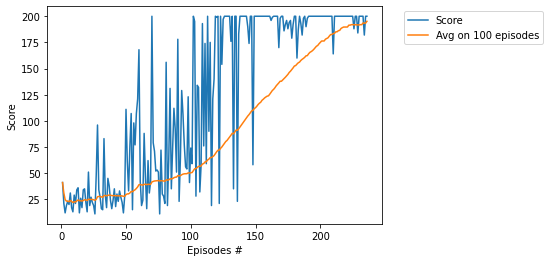

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [21]:
import plotly.graph_objs as go
import plotly.io as pio

pio.templates.default = "plotly_white"

cum_rewards = go.Scatter(x=np.arange(len(scores)), y=scores, mode='lines', name='Cumulative rewards', line=dict(color='rgb(242, 193, 189, 0.25)'))
avg_rewards = go.Scatter(x=np.arange(len(scores)), y=avg_scores, mode='lines', name='Running avg. rewards')

layout = go.Layout(title='Rewards for DDQN agent on CartPole-v0', xaxis_title='No. of episodes', yaxis_title='Rewards')
figure = go.Figure(data=[avg_rewards, cum_rewards], layout=layout)
config = {
        'toImageButtonOptions': {
            'format': 'png', # one of png, svg, jpeg, webp
            'height': 480,
            'width': 640,
            'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
        }
    }
figure.show(config=config)


In [22]:
!mkdir DDQN_weights

In [23]:
save('/content/DDQN_weights', 'cartpole-v0')

In [24]:
import pickle

DDQN_rewards = dict(cumulative_rewards=scores, running_avg_scores=avg_scores)
file = open("DDQN_rewards.pkl", "wb")
pickle.dump(DDQN_rewards, file)
file.close()

In [26]:
agent.q_local.load_state_dict(torch.load('/content/DDQN_weights/cartpole-v0_local.pth'))
states = []
rewards = []
done = False
state = env.reset()
total_reward = 0

while not done:
  action = agent.get_action(FloatTensor([state]), 0.01)
  next_state, reward, done, _ = env.step(action.item())

  total_reward += reward

  states.append(state)

  if done:
    reward = -1
    break

  state = next_state

In [27]:
states

[array([-0.0233222 ,  0.03836179, -0.02858117, -0.0171047 ]),
 array([-0.02255496, -0.15633886, -0.02892326,  0.26642528]),
 array([-0.02568174, -0.35103633, -0.02359476,  0.54984709]),
 array([-0.03270246, -0.15559104, -0.01259782,  0.24982454]),
 array([-0.03581428,  0.03970853, -0.00760133, -0.04680523]),
 array([-0.03502011, -0.15530361, -0.00853743,  0.24346975]),
 array([-0.03812619,  0.03993924, -0.00366804, -0.05189383]),
 array([-0.0373274 , -0.15512992, -0.00470591,  0.23962955]),
 array([-4.04299996e-02,  4.00589401e-02,  8.66793055e-05, -5.45340281e-02]),
 array([-0.03962882, -0.15506425, -0.001004  ,  0.23817625]),
 array([-0.04273011,  0.04007203,  0.00375952, -0.0548232 ]),
 array([-0.04192867, -0.15510363,  0.00266306,  0.23904351]),
 array([-0.04503074,  0.03998018,  0.00744393, -0.05279823]),
 array([-0.04423113,  0.23499461,  0.00638797, -0.34312327]),
 array([-0.03953124,  0.03978236, -0.0004745 , -0.04843283]),
 array([-0.0387356 , -0.15533278, -0.00144316,  0.2441

In [28]:
states = np.array(states)
states.shape

(200, 4)

Text(0.5, 1.0, 'Position using trained DDQN agent')

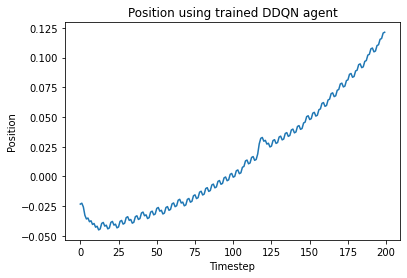

In [29]:
plt.plot(states[:, 0])
plt.xlabel("Timestep")
plt.ylabel("Position")
plt.title("Position using trained DDQN agent")

Text(0.5, 1.0, 'Angular position using trained DDQN agent')

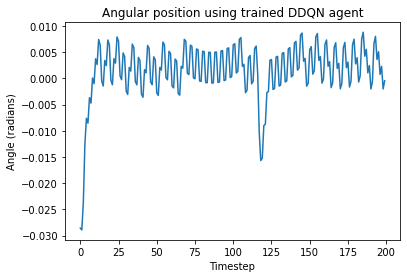

In [30]:
plt.plot(states[:, 2])
plt.xlabel("Timestep")
plt.ylabel("Angle (radians)")
plt.title("Angular position using trained DDQN agent")

In [31]:
file = open("Test_state.pkl", "wb")
pickle.dump(states, file)
file.close()